# 南アジア5国のdo介入シミュレーション
## 準備：有向重み付き隣接行列の復元
まず、NOTEARSなどで出力されたエッジリスト（edges_notears_filtered.csv）を読み込み、ノード順に沿った有向隣接行列 W を作ります。ここで
- 行インデックス = “Target”（被説明変数）
- 列インデックス = “Source”（説明変数）<br>
とし、セル(i,j) に重み Wij を格納します。

In [1]:
import pandas as pd
import numpy as np

# ① ノードリスト（NOTEARS実行時と同じ順序で並べる）
numeric_cols = [
    "mean_wbgt",
    "renewable_energy_pct",
    "fossil_fuel_pct",
    "electricity_per_capita",
    "co2_per_capita",
    "gdp_per_capita",
    "unemployment_rate",
    "health_expenditure_pct",
    "agri_valueadded_pct",
    "urbanization_pct"
]

# ② エッジリストを読み込む
edge_path = "../data/processed/panel/edges_notears_filtered.csv"
df_edges = pd.read_csv(edge_path)  # カラム: source, target, weight

# ③ 隣接行列 W を初期化（Target = rows, Source = cols）
W = pd.DataFrame(
    data=np.zeros((len(numeric_cols), len(numeric_cols))), 
    index=numeric_cols, 
    columns=numeric_cols
)

# ④ エッジごとに重みをセット
for _, row in df_edges.iterrows():
    src = row["source"]
    tgt = row["target"]
    wgt = row["weight"]
    W.at[tgt, src] = wgt

# ⑤ 確認（必要ならプリント）
print("隣接行列 W：")
print(W.round(3))


隣接行列 W：
                        mean_wbgt  renewable_energy_pct  fossil_fuel_pct  \
mean_wbgt                     0.0                   0.0              0.0   
renewable_energy_pct          0.0                   0.0              0.0   
fossil_fuel_pct               0.0                   0.0              0.0   
electricity_per_capita       -0.0                   0.0              0.0   
co2_per_capita                0.0                   0.0              0.0   
gdp_per_capita                0.0                   0.0              0.0   
unemployment_rate             0.0                   0.0              0.0   
health_expenditure_pct        0.0                   0.0              0.0   
agri_valueadded_pct           0.0                   0.0              0.0   
urbanization_pct              0.0                   0.0              0.0   

                        electricity_per_capita  co2_per_capita  \
mean_wbgt                                0.000           0.000   
renewable_energy_pct   

## 線形 SEM における全因果効果行列の計算

In [2]:
# ⑥ 単位行列 I を作成
I = np.eye(len(numeric_cols))

# ⑦ (I - W)^{-1} を計算  → Pandas DataFrame に戻す
I_minus_W = I - W.values
inv_I_minus_W = np.linalg.inv(I_minus_W)

# ⑧ 全因果効果行列 T = inv(I - W) - I
T = inv_I_minus_W - np.eye(len(numeric_cols))

# ⑨ DataFrame 化
df_T = pd.DataFrame(data=T, index=numeric_cols, columns=numeric_cols)

print("全因果効果行列 T（数値の例）：")
print(df_T.round(3))


全因果効果行列 T（数値の例）：
                        mean_wbgt  renewable_energy_pct  fossil_fuel_pct  \
mean_wbgt                     0.0                   0.0              0.0   
renewable_energy_pct          0.0                   0.0              0.0   
fossil_fuel_pct              -0.0                   0.0              0.0   
electricity_per_capita       -0.0                   0.0              0.0   
co2_per_capita               -0.0                   0.0              0.0   
gdp_per_capita               -0.0                   0.0              0.0   
unemployment_rate             0.0                   0.0             -0.0   
health_expenditure_pct        0.0                   0.0              0.0   
agri_valueadded_pct           0.0                   0.0             -0.0   
urbanization_pct              0.0                   0.0             -0.0   

                        electricity_per_capita  co2_per_capita  \
mean_wbgt                                0.000           0.000   
renewable_ener

## 介入ノード vs. 目標ノードのサブマトリクス抽出
実際に政策介入の候補となるノード（たとえばエネルギー層や気候層）を行とし、目標としたいノード（たとえば社会経済層、たとえば gdp_per_capita, unemployment_rate, health_expenditure_pct など）を列とするサブマトリクスを取り出します。

In [3]:
# ⑩ 介入ノードの候補例（気候層＋エネルギー層 = 上流にあたるノード）
intervention_nodes = [
    "mean_wbgt",
    "renewable_energy_pct",
    "fossil_fuel_pct",
    "electricity_per_capita",
    "co2_per_capita"
]

# ⑪ 目標ノードの候補例（社会経済層）
target_nodes = [
    "gdp_per_capita",
    "unemployment_rate",
    "health_expenditure_pct",
    "agri_valueadded_pct",
    "urbanization_pct"
]

# ⑫ サブマトリクスを抽出（行が各介入ノード、列が各目標ノード）
T_sub = df_T.loc[target_nodes, intervention_nodes].T
# （転置して「行: intervention, 列: target」に揃える）

print("介入ノード × 目標ノード の全因果効果サブマトリクス：")
print(T_sub.round(3))


介入ノード × 目標ノード の全因果効果サブマトリクス：
                        gdp_per_capita  unemployment_rate  \
mean_wbgt                       -0.000                0.0   
renewable_energy_pct             0.000                0.0   
fossil_fuel_pct                  0.000               -0.0   
electricity_per_capita           0.562               -0.0   
co2_per_capita                   0.302               -0.0   

                        health_expenditure_pct  agri_valueadded_pct  \
mean_wbgt                                  0.0                0.000   
renewable_energy_pct                       0.0                0.000   
fossil_fuel_pct                            0.0               -0.000   
electricity_per_capita                     0.0               -0.558   
co2_per_capita                             0.0               -0.300   

                        urbanization_pct  
mean_wbgt                          0.000  
renewable_energy_pct               0.000  
fossil_fuel_pct                   -0.000  
elect

## ヒートマップによる可視化
上記 T_sub をヒートマップとして可視化することで、どの上流ノード（行）を介入すれば下流ノード（列）にどの程度正の／負の効果があるかがひと目でわかります。

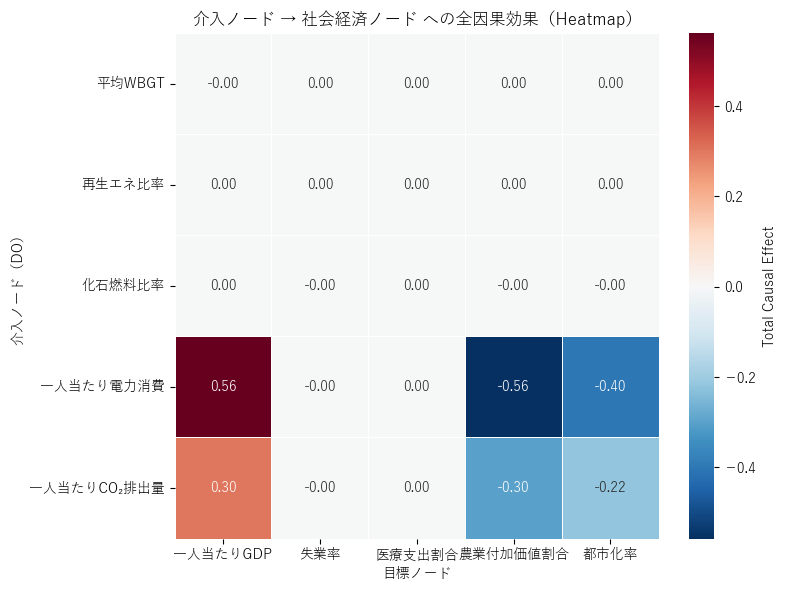

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Yu Gothic'
# ⑬ 図のサイズとフォント設定（日本語ラベル対応は必要に応じて追加）
plt.figure(figsize=(8, 6))

# 介入ノードと目標ノードを日本語訳するための辞書（日本語ラベル例）
ja_label_map = {
    "mean_wbgt": "平均WBGT",
    "renewable_energy_pct": "再生エネ比率",
    "fossil_fuel_pct": "化石燃料比率",
    "electricity_per_capita": "一人当たり電力消費",
    "co2_per_capita": "一人当たりCO₂排出量",
    "gdp_per_capita": "一人当たりGDP",
    "unemployment_rate": "失業率",
    "health_expenditure_pct": "医療支出割合",
    "agri_valueadded_pct": "農業付加価値割合",
    "urbanization_pct": "都市化率"
}

# 日本語ラベルに置き換え
T_sub_jp = T_sub.rename(index=ja_label_map, columns=ja_label_map)

# ⑭ Seaborn でヒートマップを描画
sns.heatmap(
    T_sub_jp,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",  # 正負両方を赤青で表現
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Total Causal Effect"}
)

plt.title("介入ノード → 社会経済ノード への全因果効果（Heatmap）")
plt.ylabel("介入ノード（DO）")
plt.xlabel("目標ノード")
plt.tight_layout()

# ⑮ 保存
plt.savefig("../results/intervention_heatmap.png")
plt.savefig("../results/intervention_heatmap.svg")
plt.show()


# 国別のシミュレーション

In [12]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# ─────────────────────────────────────────────
# 0) 日本語ラベルマップ
# ─────────────────────────────────────────────
ja_label_map = {
    "mean_wbgt": "平均WBGT（湿球黒球温度）",
    "renewable_energy_pct": "再生可能エネルギー比率",
    "fossil_fuel_pct": "化石燃料比率",
    "electricity_per_capita": "一人当たり電力消費量",
    "co2_per_capita": "一人当たりCO₂排出量",
    "gdp_per_capita": "一人当たりGDP",
    "unemployment_rate": "失業率",
    "health_expenditure_pct": "医療支出割合",
    "agri_valueadded_pct": "農業付加価値割合",
    "urbanization_pct": "都市化率"
}

# ─────────────────────────────────────────────
# 1) ノードリスト＆層マップの定義（全国共通）
# ─────────────────────────────────────────────
numeric_cols = [
    "mean_wbgt",
    "renewable_energy_pct",
    "fossil_fuel_pct",
    "electricity_per_capita",
    "co2_per_capita",
    "gdp_per_capita",
    "unemployment_rate",
    "health_expenditure_pct",
    "agri_valueadded_pct",
    "urbanization_pct"
]

layer_map = {
    "mean_wbgt": 0,
    "renewable_energy_pct": 1,
    "fossil_fuel_pct": 1,
    "electricity_per_capita": 1,
    "co2_per_capita": 1,
    "gdp_per_capita": 2,
    "unemployment_rate": 2,
    "health_expenditure_pct": 2,
    "agri_valueadded_pct": 2,
    "urbanization_pct": 2
}

# 介入候補ノード（気候層＋エネルギー層）
intervention_nodes = [
    "mean_wbgt",
    "renewable_energy_pct",
    "fossil_fuel_pct",
    "electricity_per_capita",
    "co2_per_capita"
]

# 目標ノード（社会経済層）
target_nodes = [
    "gdp_per_capita",
    "unemployment_rate",
    "health_expenditure_pct",
    "agri_valueadded_pct",
    "urbanization_pct"
]

# ─────────────────────────────────────────────
# 2) エッジリストを読み込み
#    カラム: country, source, target, weight
# ─────────────────────────────────────────────
df_all = pd.read_csv("../data/processed/panel/edges_no_conflicts_per_country.csv")

# ─────────────────────────────────────────────
# 3) 保存先フォルダを作成
# ─────────────────────────────────────────────
os.makedirs("../results/heatmaps_by_country", exist_ok=True)

# ─────────────────────────────────────────────
# 4) 各国ごとに処理
# ─────────────────────────────────────────────
for country, df_ct in df_all.groupby("country"):
    # --- 4-1) その国のエッジリストでグラフ構築 ---
    G = nx.DiGraph()
    G.add_nodes_from(numeric_cols)
    for _, row in df_ct.iterrows():
        src, tgt, w = row["source"], row["target"], row["weight"]
        G.add_edge(src, tgt, weight=w)
    
    # --- 4-2) 有向隣接行列 W を作成 ---
    W = pd.DataFrame(
        data=np.zeros((len(numeric_cols), len(numeric_cols))),
        index=numeric_cols,
        columns=numeric_cols
    )
    for u, v, d in G.edges(data=True):
        W.at[v, u] = d["weight"]
    
    # --- 4-3) 全因果効果行列 T を計算 ---
    I = np.eye(len(numeric_cols))
    inv_I_minus_W = np.linalg.inv(I - W.values)
    T = inv_I_minus_W - np.eye(len(numeric_cols))
    df_T = pd.DataFrame(T, index=numeric_cols, columns=numeric_cols)
    
    # --- 4-4) サブマトリクス抽出：行=介入ノード, 列=目標ノード ---
    T_sub = df_T.loc[target_nodes, intervention_nodes].T  # 介入ノードが行
    
    # --- 4-5) 日本語ラベルに置き換え ---
    T_sub_jp = T_sub.rename(index=ja_label_map, columns=ja_label_map)
    
    # --- 4-6) 値が小さい部分をマスクする（オプション） ---
    # もし 0.005 未満など「実質ゼロ」のような微小値を白くしたい場合：
    # mask = T_sub_jp.abs() < 0.005
    # T_display = T_sub_jp.mask(mask, 0.0)
    # ただし、以下では vmin/vmax 指定のみ行います。
    
    # --- 4-7) ヒートマップの描画（vmin/vmax を固定） ---
    plt.figure(figsize=(8, 6))
    
    # 各国ごとに最大絶対値を取る
    vmax = np.abs(T_sub_jp.values).max()
    vmin = -vmax
    
    sns.heatmap(
        T_sub_jp,
        annot=True,
        fmt=".2f",
        cmap="RdBu_r",
        center=0,
        vmin=vmin,
        vmax=vmax,
        linewidths=0.5,
        cbar_kws={"label": "Total Causal Effect"}
    )
    plt.title(f"{country} の介入ノード→社会経済ノード への全因果効果", fontsize=16)
    plt.ylabel("介入ノード (DO)", fontsize=14)
    plt.xlabel("目標ノード", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.yticks()
    plt.tight_layout()
    
    # --- 4-8) 画像保存 ---
    png_path = f"../results/heatmaps_by_country/{country}_heatmap.png"
    svg_path = f"../results/heatmaps_by_country/{country}_heatmap.svg"
    plt.savefig(png_path, dpi=150)
    plt.savefig(svg_path)
    plt.close()
    
    print(f"✅ {country} のヒートマップを保存しました: {png_path}")


✅ Bangladesh のヒートマップを保存しました: ../results/heatmaps_by_country/Bangladesh_heatmap.png
✅ India のヒートマップを保存しました: ../results/heatmaps_by_country/India_heatmap.png
✅ Nepal のヒートマップを保存しました: ../results/heatmaps_by_country/Nepal_heatmap.png
✅ Pakistan のヒートマップを保存しました: ../results/heatmaps_by_country/Pakistan_heatmap.png
✅ Sri Lanka のヒートマップを保存しました: ../results/heatmaps_by_country/Sri Lanka_heatmap.png


## 国別のヒートマップを一つの図にまとめる

In [15]:
import os
import math
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# ─────────────────────────────────────────────
# 0) 日本語ラベルマップ（共通）
# ─────────────────────────────────────────────
ja_label_map = {
    "mean_wbgt": "平均WBGT（湿球黒球温度）",
    "renewable_energy_pct": "再生可能エネルギー比率",
    "fossil_fuel_pct": "化石燃料比率",
    "electricity_per_capita": "一人当たり電力消費量",
    "co2_per_capita": "一人当たりCO₂排出量",
    "gdp_per_capita": "一人当たりGDP",
    "unemployment_rate": "失業率",
    "health_expenditure_pct": "医療支出割合",
    "agri_valueadded_pct": "農業付加価値割合",
    "urbanization_pct": "都市化率"
}

# ─────────────────────────────────────────────
# 1) ノードリスト＆層構造（共通）
# ─────────────────────────────────────────────
numeric_cols = [
    "mean_wbgt",
    "renewable_energy_pct",
    "fossil_fuel_pct",
    "electricity_per_capita",
    "co2_per_capita",
    "gdp_per_capita",
    "unemployment_rate",
    "health_expenditure_pct",
    "agri_valueadded_pct",
    "urbanization_pct"
]

intervention_nodes = [
    "mean_wbgt",
    "renewable_energy_pct",
    "fossil_fuel_pct",
    "electricity_per_capita",
    "co2_per_capita"
]

target_nodes = [
    "gdp_per_capita",
    "unemployment_rate",
    "health_expenditure_pct",
    "agri_valueadded_pct",
    "urbanization_pct"
]

# ─────────────────────────────────────────────
# 2) 国別エッジリストを読み込み
#    カラム: country, source, target, weight
# ─────────────────────────────────────────────
df_all = pd.read_csv("../data/processed/panel/edges_no_conflicts_per_country.csv")
countries = sorted(df_all["country"].unique())

# ─────────────────────────────────────────────
# 3) サブプロットのレイアウトを決定
#    列を3、行を自動で計算
# ─────────────────────────────────────────────
n = len(countries)
ncols = 3
nrows = math.ceil(n / ncols)

# ここを横長に変更：幅を6*ncolsに拡大
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(6 * ncols, 4 * nrows),  # ← 横幅を 6×列数、縦幅を 4×行数 に設定
    constrained_layout=True
)

# ─────────────────────────────────────────────
# 4) 各国ごとにヒートマップをサブプロット上に描画
# ─────────────────────────────────────────────
for idx, country in enumerate(countries):
    ax = axes.flat[idx]
    df_ct = df_all[df_all["country"] == country]
    
    # 4-1) 有向重み付きグラフ構築
    G = nx.DiGraph()
    G.add_nodes_from(numeric_cols)
    for _, row in df_ct.iterrows():
        G.add_edge(row["source"], row["target"], weight=row["weight"])
    
    # 4-2) 隣接行列 W を作成（Target=行, Source=列）
    W = pd.DataFrame(
        np.zeros((len(numeric_cols), len(numeric_cols))),
        index=numeric_cols, columns=numeric_cols
    )
    for u, v, d in G.edges(data=True):
        W.at[v, u] = d["weight"]
    
    # 4-3) 全因果効果行列 T = (I - W)^{-1} - I
    I = np.eye(len(numeric_cols))
    inv_I_minus_W = np.linalg.inv(I - W.values)
    T = inv_I_minus_W - np.eye(len(numeric_cols))
    df_T = pd.DataFrame(T, index=numeric_cols, columns=numeric_cols)
    
    # 4-4) サブマトリクス抽出：行=介入ノード, 列=目標ノード
    T_sub = df_T.loc[target_nodes, intervention_nodes].T
    
    # 4-5) 日本語ラベルに置き換え
    T_sub_jp = T_sub.rename(index=ja_label_map, columns=ja_label_map)
    
    # 4-6) 色スケール範囲を国別に固定
    vmax = np.abs(T_sub_jp.values).max()
    vmin = -vmax
    
    # 4-7) ヒートマップ描画（各サブプロットに色バーを付与）
    sns.heatmap(
        T_sub_jp,
        ax=ax,
        annot=True,
        fmt=".2f",
        cmap="RdBu_r",
        center=0,
        vmin=vmin,
        vmax=vmax,
        linewidths=0.5,
        cbar=True,
        cbar_kws={"shrink": 0.6, "label": "総因果効果"}
    )
    ax.set_title(country, fontsize=12)
    ax.set_ylabel("介入ノード", fontsize=10)
    ax.set_xlabel("目標ノード", fontsize=10)
    
    # 4-8) X軸ラベルの文字が重ならないように回転と位置調整
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
# 余分な空サブプロットを削除
for j in range(n, nrows * ncols):
    fig.delaxes(axes.flat[j])

# 図全体のタイトル
fig.suptitle("国別：介入ノード→社会経済ノードへの全因果効果", fontsize=16)
    
# ─────────────────────────────────────────────
# 5) 画像保存
# ─────────────────────────────────────────────
os.makedirs("../results", exist_ok=True)
out_path = "../results/combined_heatmaps_by_country.png"
fig.savefig(out_path)
print(f"✅ 国別ヒートマップをまとめて保存しました: {out_path}")
out_path = "../results/combined_heatmaps_by_country.svg"
fig.savefig(out_path)
print(f"✅ 国別ヒートマップをまとめて保存しました: {out_path}")
plt.close(fig)

✅ 国別ヒートマップをまとめて保存しました: ../results/combined_heatmaps_by_country.png
✅ 国別ヒートマップをまとめて保存しました: ../results/combined_heatmaps_by_country.svg
